In [2]:
from spikeHelper.loadSpike import loadSpikeBehav,epochData
from spikeHelper.dataOrganization import XyTfromEpoch
import pickle
import glob

binSize = 50
sigma= 100

import h5py
f = h5py.File("spikeData.hdf5", "r+")
for rat in []:
    filename='Data/r'+str(rat)+'_bin'+str(binSize)+'_sigma'+str(sigma)+'.pickle'
    
    if len(glob.glob(filename))==1:
        print('File',filename,'already exists. Loading filtered epochs')
        epochs = pickle.load(open(filename,'rb'))
        print(epochs.shape)

    else:
        print('File',filename,'does not exist. Filtering epochs and saving file')
        epochs = epochData(spikes,behavior,rat,sigma=sigma,binSize=binSize)
        pickle.dump(epochs,open(filename,'wb'))
    
    grp = f.create_group('Rat '+ str(rat))
    dset = grp.create_dataset('bin'+str(binSize)+'_sigma'+str(sigma)+'noMotor',compression='lzf',shuffle=True,data = XyTfromEpoch(epochs,getBins=[10,30],minBins=36))
    
print('Finished')

Finished


In [1]:
import scipy.io

In [57]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import scipy.stats as st
from spikeHelper.loadSpike import filterEpochs
from spikeHelper.loadSpike import precisionConvBin
def loadSpikeBehav(fileName):
    data = loadmat(fileName)

    spikes = data['dados'][0,0][1]
    behavior = data['dados'][0,0][0]

    spikes = pd.DataFrame([[ spikes[0,i][0][:,0], spikes[0,i][0][:,1]] for i in range(spikes.shape[1]) if spikes[0,i][0].shape[1]==2], columns=['times','trial'])
    behavior = pd.DataFrame(np.transpose(behavior[0,0][0]), columns=['one','onset','offset','zero','duration','sortIdx','sortLabel'])
    spikes['trialTime'] = pd.DataFrame(np.transpose([spikes.times[i] - behavior.iloc[spikes.trial[i]-1].onset.as_matrix() for i in range(spikes.shape[0])]))

    return spikes, behavior

def kernelSmooth(spikeVec, sigma):
    normKernel = st.norm(0,sigma).pdf(np.linspace(-3*sigma,3*sigma,6*sigma))
    smoothed = np.convolve(spikeVec, normKernel, 'same')
    return smoothed

def binarize(smoothed, binSize,norm=False):
    times = np.arange(len(smoothed))
    nbins = np.array(np.floor(len(smoothed)/binSize),dtype=int)
    binned = np.histogram(times, bins = nbins, range = (times[0],times[-1]), weights = smoothed[times])[0]*(1000/binSize)
    return binned

def serializeSpikes(spikeTimes, tmax, tmin=-500, dt=1):
    spikes = np.zeros(tmax-tmin)
    spikeTimeInMS = np.floor(spikeTimes*1000/dt) - tmin -1
    spikes[np.array(spikeTimeInMS,dtype=int)] = 1
    return spikes

def normEpoch(spikes,behavior,ratNumber,sigma=100):
    epochs = np.array([[spikes.trialTime[iunit][spikes.trial[iunit]==itrial] for itrial in range(1,behavior.shape[0]+1)] for iunit in range(spikes.shape[0]) ] )
    epochs = pd.DataFrame(epochs, index = ['unit'+str(i) for i in range(spikes.shape[0])], columns = ['trial '+str(i) for i in range(1,behavior.shape[0]+1)])

    # Make sure spike times are consistent with trial durations
    #assert ((1000*epochs.apply(lambda x: x.apply(mymax)).max()//1  - np.array([int(1000*behavior.duration[itrial]) for itrial in range(behavior.shape[0])]))>0).sum() == 0

    epochs = filterEpochs(epochs, method='premade', rat=ratNumber)

    for itrial in range(1,behavior.shape[0]+1):
        trialSize = int(1000*behavior.duration[itrial-1])
        binSize = int(np.floor((trialSize)/10))
        epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: serializeSpikes(x, trialSize))
        epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: kernelSmooth(x, sigma))
        epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: x[500:])
        epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: binarize(x, binSize))
    return epochs

In [5]:
import h5py
f = h5py.File("spikeData.hdf5", "r")
f

<HDF5 file "spikeData.hdf5" (mode r)>

In [47]:
behavior

,one,onset,offset,zero,duration,sortIdx,sortLabel
0,1.0,146.116813,148.409139,0.0,2.292326,0.117555,37.0
1,1.0,183.704945,184.279982,0.0,0.575037,0.132874,345.0
2,1.0,212.849418,213.241119,0.0,0.391701,0.134062,635.0
3,1.0,223.417917,223.893709,0.0,0.475791,0.138527,477.0
4,1.0,229.650637,230.018089,0.0,0.367452,0.152330,334.0
5,1.0,230.709617,231.771177,0.0,1.061560,0.156549,559.0
6,1.0,236.721152,237.256868,0.0,0.535716,0.160809,51.0
7,1.0,237.453804,238.284104,0.0,0.830300,0.165519,197.0
8,1.0,238.470635,238.636769,0.0,0.166134,0.166134,9.0
9,1.0,243.998024,245.118935,0.0,1.120911,0.167608,177.0


In [63]:
np.ceil(np.sort(np.arange(10)/3))

array([ 0.,  1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.])

In [ ]:
np.ndarray.sort()

###  Normalized bins

In [1]:
from spikeHelper.loadSpike import loadSpikeBehav,normEpoch
from spikeHelper.dataOrganization import XyTfromEpoch
import pandas as pd
import numpy as np
import pickle
import glob

binSize = 50
sigma= 100

import h5py
#f = h5py.File("spikeData.hdf5", "r+")
for rat in [7,8,9,10]:
    filename='Data/r'+str(rat)+'_sigma'+str(sigma)+'norm.pickle'
    
    if len(glob.glob(filename))==1:
        print('File',filename,'already exists. Loading filtered epochs')
        epochs = pickle.load(open(filename,'rb'))
        print(epochs.shape)

    else:
        print('File',filename,'does not exist. Filtering epochs and saving file')
        spikes,behavior = loadSpikeBehav('Data/rato'+str(rat)+'tudo.mat')
        epochs = normEpoch(spikes,behavior,rat,sigma=sigma)
        epochs = epochs[]
        pickle.dump(epochs,open(filename,'wb'))
    
    #grp = f.create_group('Rat '+ str(rat))
    #dset = grp.create_dataset('bin'+str(binSize)+'_sigma'+str(sigma)+'noMotor',compression='lzf',shuffle=True,data = XyTfromEpoch(epochs,getBins=[10,30],minBins=36))
    
print('Finished')

File Data/r7_sigma100norm.pickle does not exist. Filtering epochs and saving file
File Data/r8_sigma100norm.pickle does not exist. Filtering epochs and saving file
File Data/r9_sigma100norm.pickle does not exist. Filtering epochs and saving file
File Data/r10_sigma100norm.pickle does not exist. Filtering epochs and saving file
Finished


In [18]:
from spikeHelper.loadSpike import loadSpikeBehav,epochData
from spikeHelper.dataOrganization import XyTfromEpoch
import pandas as pd
import numpy as np
import pickle
import glob
rat = 8
spikes,behavior = loadSpikeBehav('Data/rato'+str(rat)+'tudo.mat')
epochs = epochData(spikes,behavior,rat,sigma=100,binSize='norm')


In [20]:
epochs.sample(3)

,trial 1,trial 2,trial 3,trial 4,trial 5,trial 6,trial 7,trial 8,trial 9,trial 10,...,trial 792,trial 793,trial 794,trial 795,trial 796,trial 797,trial 798,trial 799,trial 800,trial 801
unit62,"[0.555894122297, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0561669253486, 0.23140801431, 0.625171...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.19785814882, 3.07391631159, 0.465159690317,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.40266062033, 0.319007481466, 0.023943471159...","[3.68815872856, 3.73483230148, 4.15385825676, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[3.03516888093, 0.217539702713, 0.0, 0.0090964...","[0.0, 0.0, 1.31663272521, 1.40381026237, 0.0, ...","[0.0, 0.848172750047, 0.995683052646, 0.157565...","[0.0, 1.4314368389, 0.2823017729, 0.0098528522...","[5.09202173068, 2.38926294121, 0.161300871997,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.29792327491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.871...","[5.20944876816, 0.33952738357, 1.47586728891, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
unit59,"[19.3612943779, 9.83225130671, 14.6575590314, ...","[11.2608394347, 11.71362967, 14.6389642173, 17...","[48.9550495229, 50.983720608, 50.0295630643, 4...","[34.2324393026, 30.2352373365, 25.3256837988, ...","[14.8365770604, 14.7198092817, 14.7216059992, ...","[42.4199356121, 23.3548658335, 11.6741124409, ...","[35.190275906, 30.4489288071, 28.7388807474, 2...","[50.040746526, 40.0321650247, 27.4967932231, 2...","[17.6991688633, 16.476709955, 17.2266005258, 1...","[18.495818929, 21.3004169265, 26.5780983185, 2...",...,"[8.47660959182, 10.7929215051, 25.6319737693, ...","[19.1107335342, 15.3210233679, 14.5291712635, ...","[15.9985302494, 18.7934225259, 22.3093630847, ...","[11.5034024569, 14.3844362731, 16.6632883821, ...","[24.2589411748, 19.9183692922, 35.480197166, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[19.383108942, 10.1706935062, 11.2231190366, 3...","[17.4948028466, 13.9643644573, 3.81652956041, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[21.3147604624, 23.4350650531, 28.9983411784, ..."
unit27,"[0.0, 0.0, 0.0, 0.0, 0.00302369949688, 1.21460...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0524575275614, 0.161430361185, 0.39023...","[0.525447616348, 0.0295904049392, 0.0, 0.0, 0....","[0.0, 0.0, 0.0356315281549, 0.205511714609, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.29788308543, 2.56061825707, 3.13452132003, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00712717974933, 0.634334346338, 1.079404265...","[3.09729870188, 0.993741050077, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.34826701193, 0.538873382192, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [35]:
padNans

NameError: name 'padNans' is not defined

In [36]:
np.full()

<module 'numpy' from '/home/tevo/anaconda3/lib/python3.6/site-packages/numpy/__init__.py'>

In [32]:
goodEpochs = np.swapaxes(np.array([np.vstack(epochs.iloc[i]) for i in range(epochs.shape[0])]),1,2)

In [34]:
goodEpochs.shape

(37, 10, 801)

In [12]:
import pickle
data = pickle.load(open('Data/r10_bin50_sigma100.pickle','rb'))
data.shape

(65, 1671)

In [13]:
pickle.dump(data,open('Data/r10_bin50_sigma100.pickle2','wb'),protocol=2)

---

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from spikeHelper.visuals import trialNeuronPlot, firingRateEvo
from spikeHelper.loadSpike import loadSpikeBehav, filterEpochs
from spikeHelper.dataOrganization import XyTfromEpoch
from spikeHelper.filters import convHist, kernelSmooth,binarize
import pickle
import glob

%matplotlib inline

# Load Function

In [112]:
from scipy.io import loadmat
import pandas as pd
import numpy as np

rat = 7

fileName = 'Data/rato'+str(rat)+'tudo.mat'
data = loadmat(fileName)

spikes = data['dados'][0,0][1]
behavior = data['dados'][0,0][0]

spikes = pd.DataFrame([[ spikes[0,i][0][:,0], spikes[0,i][0][:,1]] for i in range(spikes.shape[1]) if spikes[0,i][0].shape[1]==2], columns=['times','trial'])
behavior = pd.DataFrame(np.transpose(behavior[0,0][0]), columns=['one','onset','offset','zero','duration','sortIdx','sortLabel'])
spikes['trialTime'] = pd.DataFrame(np.transpose([spikes.times[i] - behavior.iloc[spikes.trial[i]-1].onset.as_matrix() for i in range(spikes.shape[0])]))

In [106]:
behavior.head()

,one,onset,offset,zero,duration,sortIdx,sortLabel
0,1.0,146.116813,148.409139,0.0,2.292326,0.117555,37.0
1,1.0,183.704945,184.279982,0.0,0.575037,0.132874,345.0
2,1.0,212.849418,213.241119,0.0,0.391701,0.134062,635.0
3,1.0,223.417917,223.893709,0.0,0.475791,0.138527,477.0
4,1.0,229.650637,230.018089,0.0,0.367452,0.152330,334.0


### Now separate the activations corresponding to each trial
We will use only time relative to trial here onwards

In [107]:
from spikeHelper.loadSpike import mymax, precisionConvBin
epochs = np.array([[spikes.trialTime[iunit][spikes.trial[iunit]==itrial] for itrial in range(1,behavior.shape[0]+1)] for iunit in range(spikes.shape[0]) ] )
epochs = pd.DataFrame(epochs, index = ['unit'+str(i) for i in range(spikes.shape[0])], columns = ['trial '+str(i) for i in range(1,behavior.shape[0]+1)])

# Make sure spike times are consistent with trial durations
assert ((1000*epochs.apply(lambda x: x.apply(mymax)).max()//1  - np.array([int(1000*behavior.duration[itrial]) for itrial in range(behavior.shape[0])]))>0).sum() == 0

In [108]:
epochs.head()

,trial 1,trial 2,trial 3,trial 4,trial 5,trial 6,trial 7,trial 8,trial 9,trial 10,...,trial 792,trial 793,trial 794,trial 795,trial 796,trial 797,trial 798,trial 799,trial 800,trial 801
unit0,"[-0.0425164699554, 0.030392408371, 0.286720037...","[-0.469360589981, -0.299376726151, -0.28987383...","[-0.409763813019, -0.237117290497, -0.20406270...","[-0.0172441005707, 0.0825343132019, 0.46157813...","[-0.462561368942, -0.457277536392, -0.26214408...","[-0.412221431732, -0.313794612885, -0.00454664...","[-0.367165565491, -0.250019788742, -0.17727494...","[-0.490414142609, -0.23478269577, -0.071311473...",[0.0496027469635],"[-0.383590459824, -0.369500160217, -0.22999048...",...,"[-0.383467435837, -0.346112012863, 0.385884046...","[-0.477020263672, -0.183255195618, -0.16379904...","[-0.478863477707, -0.460636138916, -0.25059342...","[-0.497090578079, -0.196362257004, 0.063242197...","[-0.440155982971, -0.418488264084, -0.38076400...",[],"[-0.382648468018, -0.360775709152, -0.34111499...","[-0.354263067245, 0.0636928081512, 0.120709180...",[],"[-0.318750619888, -0.298844099045, -0.28835821..."
unit1,"[1.53341960907, 1.63930130005, 1.79765248299, ...","[-0.438722610474, -0.42729473114, -0.401244163...","[-0.349143028259, -0.133079051971]","[-0.347177028656, -0.300113916397, -0.27136015...","[-0.114851951599, -0.0979764461517]",[],[0.411197423935],"[-0.321454048157, 0.378798007965, 0.3975577354...","[-0.352010250092, -0.254566192627, -0.23101425...","[-0.469606399536, 0.235315084457, 1.0228121280...",...,"[-0.337428569794, -0.30875658989, -0.261734485...","[-0.103424072266, -0.05144572258, 0.0072498321...","[-0.362659931183, -0.266362905502, -0.25415682...","[-0.343859195709, -0.186286211014, -0.10309648...","[-0.208445310593, -0.166666269302, -0.02744317...",[],"[-0.080486536026, -0.0481281280518, 0.07688188...","[-0.407634019852, -0.164741039276, -0.13049864...",[],"[-0.194232225418, -0.133242845535, -0.12656641..."
unit2,"[-0.434995174408, -0.377487182617, -0.22089719...","[-0.20258808136, -0.171827077866, -0.124395608...","[-0.351231813431, 0.338943958282]","[-0.210862159729, -0.159785032272, 0.122347354...","[-0.459489345551, -0.377077817917, -0.36634635...","[-0.466001987457, -0.154009580612, -0.11722755...","[-0.161546230316, -0.10108923912, -0.082739353...","[-0.440729618073, -0.155484199524, -0.14721035...","[-0.254156589508, 0.0607438087463, 0.122511386...","[-0.34553861618, -0.21962761879, -0.2149581909...",...,"[-0.490741729736, -0.394362926483, -0.37556219...","[-0.24444937706, -0.117719173431, -0.110387325...","[-0.294420480728, -0.289464235306, -0.20807671...","[-0.495247364044, -0.109936714172, 0.335339546...","[-0.458915710449, -0.417955875397, 0.054927349...",[],"[-0.492584943771, -0.433029174805, -0.38326287...","[-0.263209104538, -0.00704526901245, 0.0921599...",[],"[-0.44425201416, -0.342097759247, -0.256286621..."
unit3,"[-0.430530548096, -0.368926525116, -0.35074043...","[-0.485171079636, -0.39907336235, -0.273612737...","[-0.435486555099, -0.341401576996, -0.31600642...","[-0.391495704651, -0.138362884521]","[-0.480460882187, -0.266977310181, -0.16076803...","[-0.280125379562, -0.170393705368, -0.14499831...","[-0.487301111221, -0.348201036453, -0.26734590...","[-0.299540519714, -0.273448944092, -0.07131147...",[-0.228966236115],"[-0.387563705444, -0.228802680969, -0.21016573...",...,"[-0.485867500305, -0.449617862701, -0.37609481...","[-0.00221180915833, 0.000900983810425, 0.00512...","[-0.47345662117, -0.460472345352, -0.380559444...","[-0.494551181793, -0.4406478405, -0.4141876697...","[-0.476979017258, -0.400260925293, -0.34406399...",[],"[-0.466657400131, -0.340049982071, -0.25337862...","[-0.430325746536, -0.385966062546, -0.31404042...",[],"[-0.485744476318, -0.427786111832, -0.35598325..."
unit4,"[-0.388464450836, -0.125255584717, -0.11182069...","[-0.467885971069, -0.355696678162, -0.16289782...","[-0.454164505005, -0.244694948196, -0.13291501...","[-0.413778066635, 0.0334234237671, 0.121241569...","[-0

### Now take out unreliable neurons 
Taking into account form, interspike interval and size

In [7]:
import pickle
def filterEpochs(epochs, minFiringRate= 4, minISI=5,method = 'premade', rat = None):
    if method == 'blind':
        goodFR = (epochs.applymap(lambda x: np.sum(x[500:])).mean(axis=1)>minFiringRate).values
        # Dump all neurons that have mean of 1 TOO FAST SPIKE per trial
        goodISI = (epochs.applymap(lambda x: np.histogram(np.diff(np.nonzero(x)),bins = minISI, range = (0,minISI))[0].sum() ).mean(axis=1) < 2).values
        return epochs.iloc[np.logical_and(goodFR,goodISI),:]
    elif method == 'premade':
        assert rat is not None
        goodNeurons = pickle.load(open('Data/goodCellsR'+str(rat)+'_withBaseDiff','rb'))==1
        return epochs.iloc[goodNeurons,:]
    else:
        raise('Nao existe metodo '+ str(method))

In [8]:
print(epochs.shape)
epochs = filterEpochs(epochs, method='premade', rat=rat)
print(epochs.shape)

(63, 801)
(37, 801)


In [13]:
orig = pd.DataFrame.copy(epochs)
orig.head()

,trial 1,trial 2,trial 3,trial 4,trial 5,trial 6,trial 7,trial 8,trial 9,trial 10,...,trial 792,trial 793,trial 794,trial 795,trial 796,trial 797,trial 798,trial 799,trial 800,trial 801
unit0,"[-0.0425164699554, 0.030392408371, 0.286720037...","[-0.469360589981, -0.299376726151, -0.28987383...","[-0.409763813019, -0.237117290497, -0.20406270...","[-0.0172441005707, 0.0825343132019, 0.46157813...","[-0.462561368942, -0.457277536392, -0.26214408...","[-0.412221431732, -0.313794612885, -0.00454664...","[-0.367165565491, -0.250019788742, -0.17727494...","[-0.490414142609, -0.23478269577, -0.071311473...",[0.0496027469635],"[-0.383590459824, -0.369500160217, -0.22999048...",...,"[-0.383467435837, -0.346112012863, 0.385884046...","[-0.477020263672, -0.183255195618, -0.16379904...","[-0.478863477707, -0.460636138916, -0.25059342...","[-0.497090578079, -0.196362257004, 0.063242197...","[-0.440155982971, -0.418488264084, -0.38076400...",[],"[-0.382648468018, -0.360775709152, -0.34111499...","[-0.354263067245, 0.0636928081512, 0.120709180...",[],"[-0.318750619888, -0.298844099045, -0.28835821..."
unit1,"[1.53341960907, 1.63930130005, 1.79765248299, ...","[-0.438722610474, -0.42729473114, -0.401244163...","[-0.349143028259, -0.133079051971]","[-0.347177028656, -0.300113916397, -0.27136015...","[-0.114851951599, -0.0979764461517]",[],[0.411197423935],"[-0.321454048157, 0.378798007965, 0.3975577354...","[-0.352010250092, -0.254566192627, -0.23101425...","[-0.469606399536, 0.235315084457, 1.0228121280...",...,"[-0.337428569794, -0.30875658989, -0.261734485...","[-0.103424072266, -0.05144572258, 0.0072498321...","[-0.362659931183, -0.266362905502, -0.25415682...","[-0.343859195709, -0.186286211014, -0.10309648...","[-0.208445310593, -0.166666269302, -0.02744317...",[],"[-0.080486536026, -0.0481281280518, 0.07688188...","[-0.407634019852, -0.164741039276, -0.13049864...",[],"[-0.194232225418, -0.133242845535, -0.12656641..."
unit2,"[-0.434995174408, -0.377487182617, -0.22089719...","[-0.20258808136, -0.171827077866, -0.124395608...","[-0.351231813431, 0.338943958282]","[-0.210862159729, -0.159785032272, 0.122347354...","[-0.459489345551, -0.377077817917, -0.36634635...","[-0.466001987457, -0.154009580612, -0.11722755...","[-0.161546230316, -0.10108923912, -0.082739353...","[-0.440729618073, -0.155484199524, -0.14721035...","[-0.254156589508, 0.0607438087463, 0.122511386...","[-0.34553861618, -0.21962761879, -0.2149581909...",...,"[-0.490741729736, -0.394362926483, -0.37556219...","[-0.24444937706, -0.117719173431, -0.110387325...","[-0.294420480728, -0.289464235306, -0.20807671...","[-0.495247364044, -0.109936714172, 0.335339546...","[-0.458915710449, -0.417955875397, 0.054927349...",[],"[-0.492584943771, -0.433029174805, -0.38326287...","[-0.263209104538, -0.00704526901245, 0.0921599...",[],"[-0.44425201416, -0.342097759247, -0.256286621..."
unit3,"[-0.430530548096, -0.368926525116, -0.35074043...","[-0.485171079636, -0.39907336235, -0.273612737...","[-0.435486555099, -0.341401576996, -0.31600642...","[-0.391495704651, -0.138362884521]","[-0.480460882187, -0.266977310181, -0.16076803...","[-0.280125379562, -0.170393705368, -0.14499831...","[-0.487301111221, -0.348201036453, -0.26734590...","[-0.299540519714, -0.273448944092, -0.07131147...",[-0.228966236115],"[-0.387563705444, -0.228802680969, -0.21016573...",...,"[-0.485867500305, -0.449617862701, -0.37609481...","[-0.00221180915833, 0.000900983810425, 0.00512...","[-0.47345662117, -0.460472345352, -0.380559444...","[-0.494551181793, -0.4406478405, -0.4141876697...","[-0.476979017258, -0.400260925293, -0.34406399...",[],"[-0.466657400131, -0.340049982071, -0.25337862...","[-0.430325746536, -0.385966062546, -0.31404042...",[],"[-0.485744476318, -0.427786111832, -0.35598325..."
unit4,"[-0.388464450836, -0.125255584717, -0.11182069...","[-0.467885971069, -0.355696678162, -0.16289782...","[-0.454164505005, -0.244694948196, -0.13291501...","[-0.413778066635, 0.0334234237671, 0.121241569...","[-0

In [72]:
from spikeHelper.loadSpike import mymax
orig.applymap(mymax).max()

trial 1      2.288640
trial 2      0.573399
trial 3      0.385147
trial 4      0.474522
trial 5      0.363315
trial 6      1.060700
trial 7      0.534159
trial 8      0.827801
trial 9      0.156959
trial 10     1.119724
trial 11     0.557138
trial 12     1.682350
trial 13     1.841521
trial 14     1.698529
trial 15     1.320673
trial 16     1.353769
trial 17     3.071017
trial 18     1.066476
trial 19     0.962683
trial 20     2.190377
trial 21     1.329275
trial 22     0.873718
trial 23     0.897147
trial 24     4.380385
trial 25     1.167933
trial 26     2.008351
trial 27     1.764147
trial 28     1.818542
trial 29     2.653143
trial 30     1.578967
               ...   
trial 772    1.535386
trial 773    4.123361
trial 774    0.936100
trial 775    2.209956
trial 776    2.741862
trial 777    2.922537
trial 778    5.055201
trial 779    2.303918
trial 780    2.004705
trial 781    1.457807
trial 782    5.087682
trial 783    4.327752
trial 784    1.415332
trial 785    0.960635
trial 786 

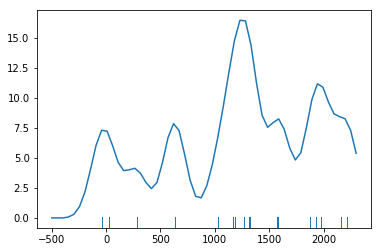

In [102]:
from spikeHelper.loadSpike import serializeSpikes
from spikeHelper.filters import convHist
sigma = 100;binSize=50
plt.plot(np.linspace(-500,2300,int(2800/binSize) ),convHist((serializeSpikes(orig['trial 1']['unit0'],2300)), sigma=sigma,binSize=binSize))
sns.rugplot(orig['trial 1']['unit0']*1000)

### Bin trials

In [49]:
epochs = pd.DataFrame.copy(orig)

In [50]:
for itrial in range(1,behavior.shape[0]+1):
    func = lambda x: precisionConvBin(x, int(1000*behavior.duration[itrial-1]), sigma=100, binSize=50)
    epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(func)

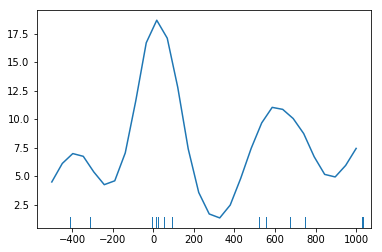

In [51]:
plt.plot(np.linspace(-500,1000,30),epochs['trial 6']['unit0'][:30])
sns.rugplot(orig['trial 6']['unit0']*1000)

In [28]:
orig['trial 1']['unit0']*1000

array([  -42.51646996,    30.39240837,   286.72003746,   632.75027275,
         637.99309731,  1033.01119804,  1169.32606697,  1189.06879425,
        1268.81790161,  1316.08581543,  1321.32863998,  1575.11687279,
        1584.53774452,  1871.99497223,  1933.51697922,  1975.41904449,
        2156.09359741,  2219.41781044])

In [40]:
t=np.ceil((.5+ behavior.duration)*(1000/50))==epochs.applymap(len).iloc[0].values

In [25]:
epochs.applymap(len).iloc[:,t.values==False]

,trial 13,trial 35,trial 39,trial 46,trial 86,trial 90,trial 104,trial 231,trial 239,trial 350,trial 385,trial 433,trial 587,trial 590,trial 641,trial 663,trial 766,trial 782
unit0,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112
unit1,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112
unit2,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112
unit3,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112
unit4,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112
unit5,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112
unit6,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112
unit7,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112
unit8,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112
unit9,47,15,37,16,34,47,93,49,40,63,30,47,19,95,81,43,38,112


---

In [ ]:
filename = 'Data/rato10tudo.mat'
spikes, behavior, epochs = loadSpikeBehav(filename)

# Load all

In [4]:
for rat in [7,8,9,10]:
    #fr=1; isi=5; filename = 'Data/r'+str(rat)+'_filtered_epoch_fr'+str(fr)+'_isi'+str(isi)+'.pickle'
    filename = 'Data/r'+str(rat)+'_filtered_epoch_gabi.pickle'

    if len(glob.glob(filename))==1:
        print('File',filename,'already exists. Loading filtered epochs')
        epochs = pickle.load(open(filename,'rb'))

    else:
        print('File',filename,'does not exist. Filtering epochs and saving file')
        epochs = filterEpochs(epochs,minFiringRate=fr,minISI=isi,method = 'gabi', rat = rat)
        pickle.dump(epochs,open(filename,'wb'))
        
    #trialsOfInterest = (behavior.duration>1).as_matrix() # another option for selecting duration
    duration= epochs.applymap(len).iloc[0].values
    
    ############# SPECIFICS ##############
    epochs = epochs.iloc[:,duration>1300]
    print(epochs.shape)
    subname = '1300msPlus1s'
    binDuration=50
    ############# SPECIFICS ##############
    
    data = XyTfromEpoch(epochs,window=[0,1000],binDuration=binDuration)
    pickle.dump(data,open('Data/'+str(binDuration)+'ms_r'+str(rat)+'_'+subname+'.pickle','wb'))
    print('Done with rat', rat)

File Data/r7_filtered_epoch_gabi.pickle already exists. Loading filtered epochs
(29, 955)
File Data/r8_filtered_epoch_gabi.pickle already exists. Loading filtered epochs
(37, 671)
File Data/r9_filtered_epoch_gabi.pickle already exists. Loading filtered epochs
(29, 683)
File Data/r10_filtered_epoch_gabi.pickle already exists. Loading filtered epochs
(65, 1429)


In [5]:
print('hello world')

hello world


-----------